In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas 
import matplotlib.pyplot as plt
import re
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from pymystem3 import Mystem


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split



russian_stopwords = stopwords.words("russian")
path = "C:\\Proganiy\\pp-laba3\\annotation.csv"
print(russian_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [77]:
def create_ann(annatation: str) -> pandas.DataFrame:

    """Создаёт датафрейм по пути аннатации"""

    frame = pandas.DataFrame(columns =["Оценка","Kоличество слов","Текст рецензии"])
    ann_temp = open(annatation, "r", encoding="utf-8")
    for otzv in ann_temp.readlines():
        mas_otzv = otzv.split(",")
        otzv_temp = open(mas_otzv[0],"r",encoding="utf-8")
        otzv_text = " ".join(otzv_temp)
        row = pandas.Series({"Оценка": int(mas_otzv[2])-1,"Kоличество слов": len(otzv_text), "Текст рецензии": otzv_text})
        new_row = pandas.DataFrame([row], columns=frame.columns)
        frame = pandas.concat([frame, new_row], ignore_index=True)
    frame.dropna()
    return frame

data = create_ann(path)
print(data)

     Оценка Kоличество слов                                     Текст рецензии
0         0            1853  11 марта этого года переводила 145 в Германию(...
1         0            4278  В пятницу, 22 апреля 2022 г. Сбербанк заблокир...
2         0            2035  Здравствуйте. Перед оформлением досудебной пре...
3         0            3503  Я являюсь клиентом Сбербанка уже более десяти ...
4         0            3340  Призываю предпринимателей подумать дважды, пре...
...     ...             ...                                                ...
2995      4             304  Сегодня хочу рассказать о Сбербанке. В этом пр...
2996      4             863  Банк Сбербанк - это прекрасное финансовое учре...
2997      4             979  Пользуюсь сбербанком сколько себя помню, зарпл...
2998      4            2084  Я не сразу научилась пользоваться кредитной сб...
2999      4             777  Пользуюсь сбербанком давно, никаких нарекании ...

[3000 rows x 3 columns]


In [78]:
def clean (frame: pandas.DataFrame) -> pandas.DataFrame:
    frame["Текст рецензии"] = frame["Текст рецензии"].apply(delete_punc)
    frame["Текст рецензии"] = frame["Текст рецензии"].apply(Mystem().lemmatize)
    frame["Текст рецензии"] = frame["Текст рецензии"].apply(lambda x: ' '.join(x))
    frame["Текст рецензии"] = frame["Текст рецензии"].apply(word_tokenize)
    frame["Текст рецензии"] = frame["Текст рецензии"].apply(lambda x: ' '.join(x))
    return frame

def delete_punc(strings: str) -> str:
    punc = '''!()-[]{};:'",<>./?@#$%^&*~1234567890'''
    for char in strings:
        if char in punc:
            strings = strings.replace(char, "")
    return strings

data = clean(data)
print(data)

     Оценка Kоличество слов                                     Текст рецензии
0         0            1853  март этот год переводить в германиюденежный ср...
1         0            4278  в пятница апрель г сбербанк заблокировать мой ...
2         0            2035  здравствовать перед оформление досудебный прет...
3         0            3503  я являться клиент сбербанк уже много десять го...
4         0            3340  призывать предприниматель подумать дважды преж...
...     ...             ...                                                ...
2995      4             304  сегодня хотеть рассказывать о сбербанк в это п...
2996      4             863  банк сбербанк это прекрасный финансовый учрежд...
2997      4             979  пользоваться сбербанк сколько себя помнить зар...
2998      4            2084  я не сразу научаться пользоваться кредитный сб...
2999      4             777  пользоваться сбербанк давно никакой нарекание ...

[3000 rows x 3 columns]


In [79]:
max_words = 10000
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(data['Текст рецензии']).toarray()
sparse_matrix.shape

print(type(np.array(data['Оценка'])))

<class 'numpy.ndarray'>


In [9]:
data['Оценка'] = data['Оценка'].astype (str).astype(int)
a=np.array(data['Оценка'])
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['Оценка']), test_size=0.1)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
criterion = nn.CrossEntropyLoss()
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

{0: 537, 1: 547, 2: 546, 3: 542, 4: 528}


In [10]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 500)
        self.linear2 = nn.Linear(500, 100)
        self.linear3 = nn.Linear(100, 5)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=1)


Epoch: 1, Loss: 1.6095131635665894, Accuracy: 20.22222137451172%
Epoch: 2, Loss: 1.5811342000961304, Accuracy: 25.592592239379883%
Epoch: 3, Loss: 1.5718399286270142, Accuracy: 29.037036895751953%
Epoch: 4, Loss: 1.6005134582519531, Accuracy: 27.851852416992188%
Epoch: 5, Loss: 1.50630784034729, Accuracy: 44.44444274902344%
Epoch: 6, Loss: 1.4779762029647827, Accuracy: 45.296295166015625%
Epoch: 7, Loss: 1.455392837524414, Accuracy: 43.185184478759766%
Epoch: 8, Loss: 1.4450244903564453, Accuracy: 43.77777862548828%
Epoch: 9, Loss: 1.413206696510315, Accuracy: 47.85185241699219%
Epoch: 10, Loss: 1.3682334423065186, Accuracy: 52.703704833984375%
Epoch: 11, Loss: 1.3102041482925415, Accuracy: 60.407405853271484%
Epoch: 12, Loss: 1.2669779062271118, Accuracy: 64.88888549804688%
Epoch: 13, Loss: 1.2290754318237305, Accuracy: 68.48148345947266%
Epoch: 14, Loss: 1.2081027030944824, Accuracy: 70.25926208496094%
Epoch: 15, Loss: 1.1922588348388672, Accuracy: 71.48148345947266%
Epoch: 16, Loss:

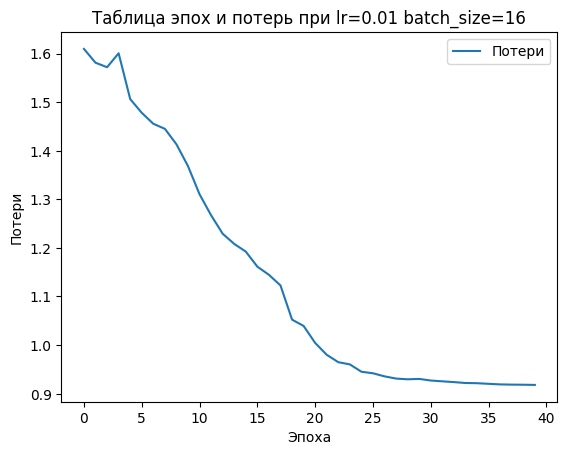

Epoch: 1, Loss: 1.6096034049987793, Accuracy: 19.814815521240234%
Epoch: 2, Loss: 1.599932312965393, Accuracy: 21.074073791503906%
Epoch: 3, Loss: 1.572849154472351, Accuracy: 25.44444465637207%
Epoch: 4, Loss: 1.530542016029358, Accuracy: 37.14814758300781%
Epoch: 5, Loss: 1.4982577562332153, Accuracy: 42.44444274902344%
Epoch: 6, Loss: 1.486572265625, Accuracy: 37.55555725097656%
Epoch: 7, Loss: 1.4613327980041504, Accuracy: 40.185184478759766%
Epoch: 8, Loss: 1.3904551267623901, Accuracy: 51.925926208496094%
Epoch: 9, Loss: 1.3057376146316528, Accuracy: 61.62963104248047%
Epoch: 10, Loss: 1.264250636100769, Accuracy: 68.44444274902344%
Epoch: 11, Loss: 1.2018449306488037, Accuracy: 74.9259262084961%
Epoch: 12, Loss: 1.1566097736358643, Accuracy: 80.85185241699219%
Epoch: 13, Loss: 1.0822272300720215, Accuracy: 86.81481170654297%
Epoch: 14, Loss: 1.0478860139846802, Accuracy: 88.77777862548828%
Epoch: 15, Loss: 1.0195224285125732, Accuracy: 91.14814758300781%
Epoch: 16, Loss: 0.98563

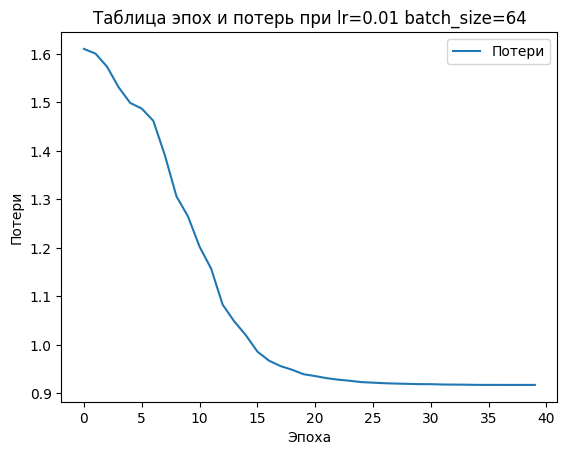

Epoch: 1, Loss: 1.6093708276748657, Accuracy: 22.185184478759766%
Epoch: 2, Loss: 1.5908160209655762, Accuracy: 31.0%
Epoch: 3, Loss: 1.5627940893173218, Accuracy: 29.481481552124023%
Epoch: 4, Loss: 1.5502265691757202, Accuracy: 41.296295166015625%
Epoch: 5, Loss: 1.4918150901794434, Accuracy: 49.0%
Epoch: 6, Loss: 1.4970388412475586, Accuracy: 38.074073791503906%
Epoch: 7, Loss: 1.4457697868347168, Accuracy: 47.33333206176758%
Epoch: 8, Loss: 1.4899653196334839, Accuracy: 38.14814758300781%
Epoch: 9, Loss: 1.4792205095291138, Accuracy: 39.407405853271484%
Epoch: 10, Loss: 1.3954739570617676, Accuracy: 49.11111068725586%
Epoch: 11, Loss: 1.3813475370407104, Accuracy: 51.25925827026367%
Epoch: 12, Loss: 1.3397085666656494, Accuracy: 57.296295166015625%
Epoch: 13, Loss: 1.2362874746322632, Accuracy: 68.22222137451172%
Epoch: 14, Loss: 1.2402970790863037, Accuracy: 66.81481170654297%
Epoch: 15, Loss: 1.227932333946228, Accuracy: 68.29629516601562%
Epoch: 16, Loss: 1.2093636989593506, Acc

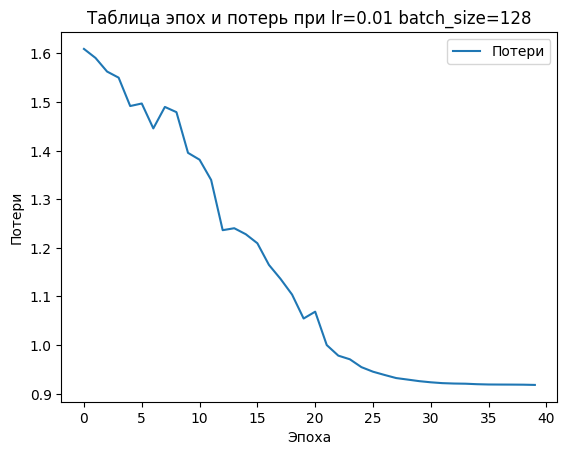

Epoch: 1, Loss: 1.6094681024551392, Accuracy: 20.740739822387695%
Epoch: 2, Loss: 1.6025089025497437, Accuracy: 33.703704833984375%
Epoch: 3, Loss: 1.5913349390029907, Accuracy: 39.33333206176758%
Epoch: 4, Loss: 1.5760911703109741, Accuracy: 40.62963104248047%
Epoch: 5, Loss: 1.5559886693954468, Accuracy: 46.62963104248047%
Epoch: 6, Loss: 1.5315512418746948, Accuracy: 61.51852035522461%
Epoch: 7, Loss: 1.5030691623687744, Accuracy: 67.55555725097656%
Epoch: 8, Loss: 1.4708973169326782, Accuracy: 71.55555725097656%
Epoch: 9, Loss: 1.4363125562667847, Accuracy: 74.88888549804688%
Epoch: 10, Loss: 1.4005860090255737, Accuracy: 77.88888549804688%
Epoch: 11, Loss: 1.3642514944076538, Accuracy: 79.66666412353516%
Epoch: 12, Loss: 1.3281477689743042, Accuracy: 80.59259033203125%
Epoch: 13, Loss: 1.292992115020752, Accuracy: 81.22222137451172%
Epoch: 14, Loss: 1.2587038278579712, Accuracy: 82.96295928955078%
Epoch: 15, Loss: 1.2261908054351807, Accuracy: 84.11111450195312%
Epoch: 16, Loss: 1

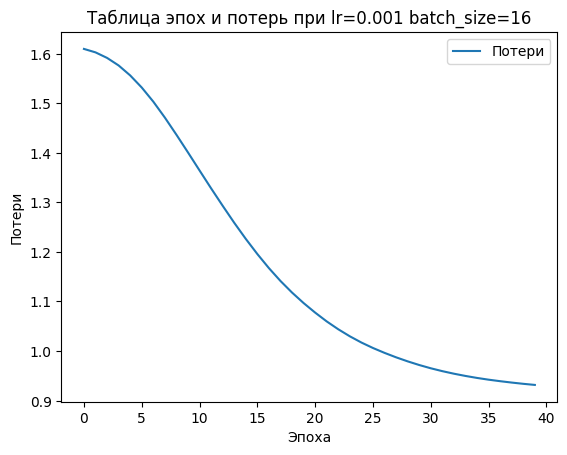

Epoch: 1, Loss: 1.6092350482940674, Accuracy: 19.851852416992188%
Epoch: 2, Loss: 1.601117491722107, Accuracy: 27.0%
Epoch: 3, Loss: 1.5901771783828735, Accuracy: 38.44444274902344%
Epoch: 4, Loss: 1.5753411054611206, Accuracy: 45.33333206176758%
Epoch: 5, Loss: 1.556425929069519, Accuracy: 50.85185241699219%
Epoch: 6, Loss: 1.5345371961593628, Accuracy: 55.85185241699219%
Epoch: 7, Loss: 1.5091456174850464, Accuracy: 60.44444274902344%
Epoch: 8, Loss: 1.4812946319580078, Accuracy: 62.11111068725586%
Epoch: 9, Loss: 1.4514570236206055, Accuracy: 63.44444274902344%
Epoch: 10, Loss: 1.4206799268722534, Accuracy: 64.25926208496094%
Epoch: 11, Loss: 1.389514684677124, Accuracy: 66.25926208496094%
Epoch: 12, Loss: 1.358413577079773, Accuracy: 68.55555725097656%
Epoch: 13, Loss: 1.3265831470489502, Accuracy: 72.77777862548828%
Epoch: 14, Loss: 1.2937617301940918, Accuracy: 79.25926208496094%
Epoch: 15, Loss: 1.2617440223693848, Accuracy: 83.11111450195312%
Epoch: 16, Loss: 1.2311031818389893

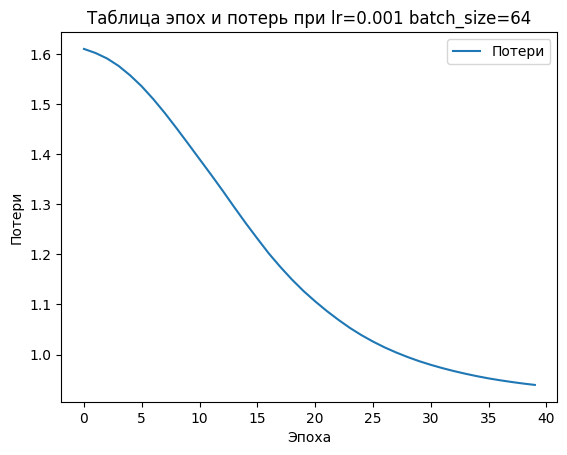

Epoch: 1, Loss: 1.6097527742385864, Accuracy: 17.740739822387695%
Epoch: 2, Loss: 1.6027926206588745, Accuracy: 24.185184478759766%
Epoch: 3, Loss: 1.5919129848480225, Accuracy: 25.851852416992188%
Epoch: 4, Loss: 1.5759007930755615, Accuracy: 37.37036895751953%
Epoch: 5, Loss: 1.5551426410675049, Accuracy: 53.25925827026367%
Epoch: 6, Loss: 1.5305585861206055, Accuracy: 60.66666793823242%
Epoch: 7, Loss: 1.5016924142837524, Accuracy: 64.88888549804688%
Epoch: 8, Loss: 1.4692972898483276, Accuracy: 69.22222137451172%
Epoch: 9, Loss: 1.4346401691436768, Accuracy: 72.11111450195312%
Epoch: 10, Loss: 1.3984825611114502, Accuracy: 74.29629516601562%
Epoch: 11, Loss: 1.3619306087493896, Accuracy: 76.74073791503906%
Epoch: 12, Loss: 1.3259178400039673, Accuracy: 78.18518829345703%
Epoch: 13, Loss: 1.2909352779388428, Accuracy: 79.0740737915039%
Epoch: 14, Loss: 1.2573882341384888, Accuracy: 80.25926208496094%
Epoch: 15, Loss: 1.2254639863967896, Accuracy: 82.29629516601562%
Epoch: 16, Loss: 

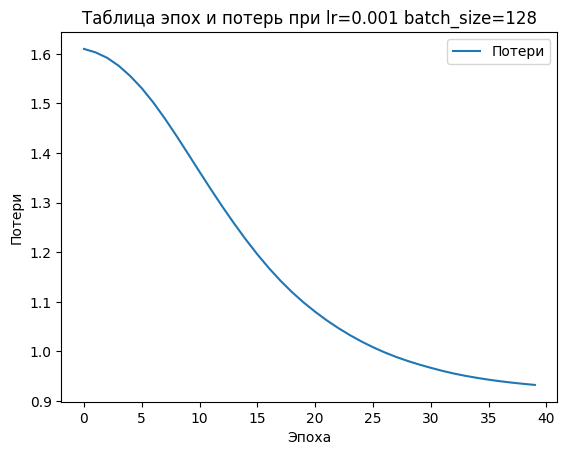

Epoch: 1, Loss: 1.6095319986343384, Accuracy: 20.037036895751953%
Epoch: 2, Loss: 1.6085015535354614, Accuracy: 24.407407760620117%
Epoch: 3, Loss: 1.6075160503387451, Accuracy: 29.77777862548828%
Epoch: 4, Loss: 1.6065338850021362, Accuracy: 33.96296310424805%
Epoch: 5, Loss: 1.6055247783660889, Accuracy: 37.407405853271484%
Epoch: 6, Loss: 1.6044683456420898, Accuracy: 39.51852035522461%
Epoch: 7, Loss: 1.6033378839492798, Accuracy: 41.74074172973633%
Epoch: 8, Loss: 1.6021214723587036, Accuracy: 43.11111068725586%
Epoch: 9, Loss: 1.6008212566375732, Accuracy: 44.925926208496094%
Epoch: 10, Loss: 1.5994362831115723, Accuracy: 46.11111068725586%
Epoch: 11, Loss: 1.5979667901992798, Accuracy: 47.03703689575195%
Epoch: 12, Loss: 1.5964051485061646, Accuracy: 48.22222137451172%
Epoch: 13, Loss: 1.5947489738464355, Accuracy: 49.22222137451172%
Epoch: 14, Loss: 1.5929906368255615, Accuracy: 50.25925827026367%
Epoch: 15, Loss: 1.5911260843276978, Accuracy: 51.185184478759766%
Epoch: 16, Los

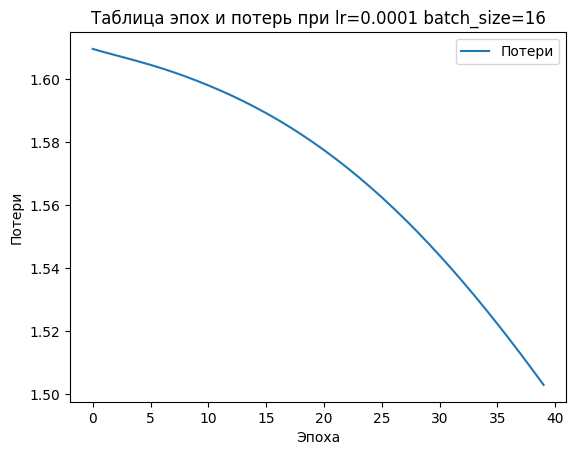

Epoch: 1, Loss: 1.6093493700027466, Accuracy: 20.814815521240234%
Epoch: 2, Loss: 1.6082508563995361, Accuracy: 24.55555534362793%
Epoch: 3, Loss: 1.6071820259094238, Accuracy: 25.074073791503906%
Epoch: 4, Loss: 1.606114149093628, Accuracy: 25.0%
Epoch: 5, Loss: 1.6050220727920532, Accuracy: 25.481481552124023%
Epoch: 6, Loss: 1.6038992404937744, Accuracy: 25.77777862548828%
Epoch: 7, Loss: 1.6027191877365112, Accuracy: 26.185184478759766%
Epoch: 8, Loss: 1.6014747619628906, Accuracy: 27.33333396911621%
Epoch: 9, Loss: 1.6001636981964111, Accuracy: 28.11111068725586%
Epoch: 10, Loss: 1.5987762212753296, Accuracy: 29.370370864868164%
Epoch: 11, Loss: 1.597308874130249, Accuracy: 30.814815521240234%
Epoch: 12, Loss: 1.5957618951797485, Accuracy: 31.592592239379883%
Epoch: 13, Loss: 1.5941272974014282, Accuracy: 32.62963104248047%
Epoch: 14, Loss: 1.5924032926559448, Accuracy: 33.296295166015625%
Epoch: 15, Loss: 1.5905864238739014, Accuracy: 34.44444274902344%
Epoch: 16, Loss: 1.5886713

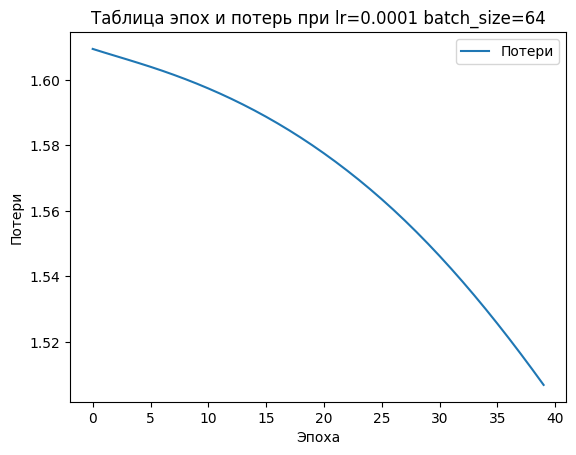

Epoch: 1, Loss: 1.6093158721923828, Accuracy: 22.703702926635742%
Epoch: 2, Loss: 1.608202576637268, Accuracy: 27.925926208496094%
Epoch: 3, Loss: 1.6071186065673828, Accuracy: 29.481481552124023%
Epoch: 4, Loss: 1.6060196161270142, Accuracy: 29.851852416992188%
Epoch: 5, Loss: 1.6048799753189087, Accuracy: 30.22222137451172%
Epoch: 6, Loss: 1.6036890745162964, Accuracy: 30.740739822387695%
Epoch: 7, Loss: 1.6024408340454102, Accuracy: 31.185184478759766%
Epoch: 8, Loss: 1.6011277437210083, Accuracy: 31.518518447875977%
Epoch: 9, Loss: 1.5997440814971924, Accuracy: 32.185184478759766%
Epoch: 10, Loss: 1.598284363746643, Accuracy: 32.814815521240234%
Epoch: 11, Loss: 1.5967437028884888, Accuracy: 34.03703689575195%
Epoch: 12, Loss: 1.5951155424118042, Accuracy: 34.77777862548828%
Epoch: 13, Loss: 1.5933960676193237, Accuracy: 35.407405853271484%
Epoch: 14, Loss: 1.5915825366973877, Accuracy: 36.185184478759766%
Epoch: 15, Loss: 1.5896787643432617, Accuracy: 36.925926208496094%
Epoch: 16

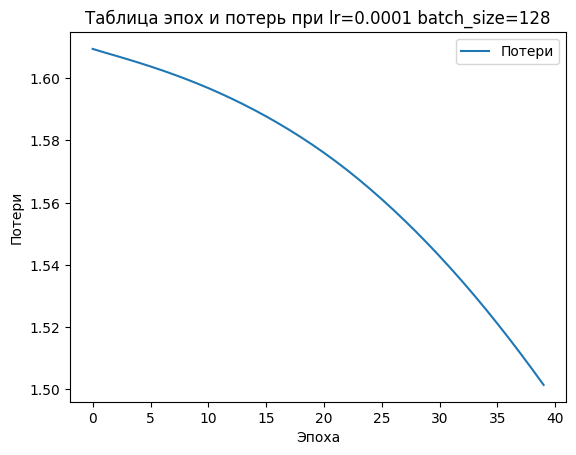

In [32]:
learning = [0.01, 0.001, 0.0001]
batch = [16, 64, 128]
count = 1
for l in learning:
    for b in batch:
        model = LogisticRegression()
        optimizer = torch.optim.Adam(params=model.parameters() , lr=l)
        data=torch.utils.data.DataLoader(x_train, batch_size=b, shuffle=True)
        val_data = torch.utils.data.DataLoader(x_test, batch_size=b, shuffle=True)
        epochs = 40
        model.train()
        loss_ = []
        for epoch in range(epochs):
            loss = []
            loss_values = []
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss_.append(loss.item())
            loss_values.append(loss.item())
            pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
            acc = pred * 100.0 / len(x_train)
            print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
            loss.backward()
            optimizer.step()
        torch.save(model,'C:\\Proganiy\\pp-laba5\\'+str(count)+'.pt')
        count+=1
        plt.plot(loss_)
        plt.title('Таблица эпох и потерь при lr='+str(l) +" batch_size="+str(b))
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.legend(['Потери'])
        plt.show()

In [69]:
down = torch.load("C:\\Proganiy\\pp-laba5\\4.pt")
down

LogisticRegression(
  (linear1): Linear(in_features=10000, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=5, bias=True)
)

In [70]:

down.eval()
with torch.no_grad():
    y_pred = down(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

Accuracy : 45.66666793823242%
